In [2]:
using Revise

In [3]:
import QCMaterial: uccgsd, convert_openfermion_op, up_index, down_index

In [4]:
using PyCall
using HDF5

In [5]:
plt = pyimport("matplotlib.pyplot")
of = pyimport("openfermion")
ofpyscf = pyimport("openfermionpyscf")
qulacs = pyimport("qulacs")
scipy_opt = pyimport("scipy.optimize")
get_fermion_operator = of.transforms.get_fermion_operator
jordan_wigner = of.transforms.jordan_wigner
jw_get_ground_state_at_particle_number = of.linalg.sparse_tools.jw_get_ground_state_at_particle_number
get_number_preserving_sparse_operator = of.linalg.get_number_preserving_sparse_operator
FermionOperator = of.ops.operators.FermionOperator

PyObject <class 'openfermion.ops.operators.fermion_operator.FermionOperator'>

In [6]:
includet("./uccgsd_hubbard.jl")

In [7]:
nsite = 2
ham = generate_ham(nsite)
n_qubit = 2*nsite

4

In [8]:
theta_list = h5read("opt.h5", "theta_list")
exact_gs_ene = h5read("opt.h5", "exact_gs_ene")
cost_history = h5read("opt.h5", "cost_history")
n_electron = h5read("opt.h5", "n_electron")
;

VQEの収束状況をプロットする。

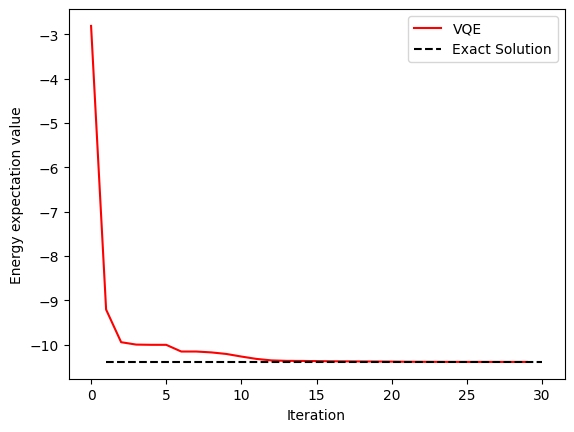

In [9]:
import PyPlot

PyPlot.plot(cost_history, color="red", label="VQE")
PyPlot.plot(1:length(cost_history), fill(exact_gs_ene, length(cost_history)),
    linestyle="dashed", color="black", label="Exact Solution")
PyPlot.xlabel("Iteration")
PyPlot.ylabel("Energy expectation value")
PyPlot.legend()
PyPlot.show()

In [11]:
circuit, theta_offsets, qulacs_hamiltonian = construct_circuit(ham)

(PyObject *** Quantum Circuit Info ***
# of qubit: 4
# of step : 336
# of gate : 336
# of 1 qubit gate: 0
# of 2 qubit gate: 44
# of 3 qubit gate: 64
# of 4 qubit gate: 228
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 336
, Any[Any[2, 0, [-0.5, 0.5]], Any[2, 2, [0.5, -0.5]], Any[2, 4, [-0.5, 0.5]], Any[2, 6, [0.5, -0.5]], Any[2, 8, [-0.5, 0.5]], Any[2, 10, [0.5, -0.5]], Any[2, 12, [-0.5, 0.5]], Any[2, 14, [0.5, -0.5]], Any[0, 16, Float64[]], Any[4, 16, [0.25, 0.25, -0.25, -0.25]]  …  Any[8, 292, [0.125, 0.125, 0.125, -0.125, -0.125, -0.125, -0.125, 0.125]], Any[4, 300, [0.25, -0.25, 0.25, -0.25]], Any[4, 304, [-0.25, -0.25, 0.25, 0.25]], Any[8, 308, [-0.125, -0.125, -0.125, 0.125, 0.125, 0.125, 0.125, -0.125]], Any[8, 316, [-0.125, -0.125, 0.125, -0.125, 0.125, -0.125, 0.125, 0.125]], Any[4, 324, [-0.25, 0.25, -0.25, 0.25]], Any[0, 328, Float64[]], Any[4, 328, [-0.25, 0.25, -0.25, 0.25]], Any[4, 332, [0.25, -0.25, 0.25, -0.25]], Any[0, 336, Float64[]]], PyObjec

In [12]:
divide_real_imag_openfermion(op) = 
    (op+of.utils.hermitian_conjugated(op))/2, (op-of.utils.hermitian_conjugated(op))/2im

function make_rdm1(state, n_qubit)
    one_rdm = zeros(Complex{Float64}, n_qubit, n_qubit)
    for p in 1:n_qubit, q in 1:n_qubit
        jw_hamiltonian = jordan_wigner(of.ops.FermionOperator(((p-1, 1), (q-1, 0))))
        her, antiher = divide_real_imag_openfermion(jw_hamiltonian)
        qulacs_hamiltonian_real = convert_openfermion_op(n_qubit, her)
        qulacs_hamiltonian_imag = convert_openfermion_op(n_qubit, antiher)
        pq_one_rdm_real = qulacs_hamiltonian_real.get_expectation_value(state)
        pq_one_rdm_imag = qulacs_hamiltonian_imag.get_expectation_value(state)
        one_rdm[p, q] = pq_one_rdm_real + pq_one_rdm_imag * im
    end
    one_rdm
end

make_rdm1 (generic function with 1 method)

## 縮約密度行列の計算法
以下のコードブロックでは、VQE波動関数から１次の縮約密度行列
$$
\gamma_{pq} =
\langle \Psi |
a^{\dagger}_p a_q
|\Psi \rangle 
$$
を計算する方法を示す。

In [13]:
import LinearAlgebra

state = qulacs.QuantumState(n_qubit) 
state.set_computational_basis(hfstate(n_qubit, n_electron))# Hartree-Fock State
rdm_hf = make_rdm1(state, n_qubit)
println("RDM of HF")
println(rdm_hf)
println("Number of electrons (HF)")
println(real(LinearAlgebra.tr(rdm_hf)))

circuit.update_quantum_state(state) #量子回路を状態に作用
rdm_uccsd = make_rdm1(state, n_qubit)
println("RDM of UCCSD")
println(rdm_uccsd)
println("Number of electrons (UCCSD)")
println(real(LinearAlgebra.tr(rdm_hf)))    

RDM of HF
Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
Number of electrons (HF)
2.0
RDM of UCCSD
Complex{Float64}[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]
Number of electrons (UCCSD)
2.0
